Presented by:

Maria DJADI 191939083397

# Importing libraries

Here I imported all the necessary libraries for the spam classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay

import torch
import torch.nn as nn


import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


import os
import random


# Loading data

To load the data, the following steps were taken:
1. Data paths were defined and stored in variables corresponding to different types of email data: `easy_ham_path`, `hard_ham_path`, and `spam_2_path`.

2. A dataframe was constructed with two columns: "Text" (representing the core content of the emails) and "Label" (with values of 0 for ham and 1 for spam).

3. A function named `load_data` was defined, which accepts a `path` and a `label` as inputs. This function reads the email texts from the specified path, associates them with the given label, and returns a dataframe containing the email texts along with their corresponding labels.

4. By calling the `load_data` function, three separate dataframes were created. Two of them consisted of easy ham and hard ham emails, while the third one contained spam emails.

5. All three dataframes were combined into a single dataframe using the concatenation operation. Subsequently, the data was shuffled to ensure randomization and avoid any bias in the order of the emails.

These steps were followed to effectively load the email data, organize it into appropriate data structures, and prepare it for further analysis and modeling.

In [2]:
easy_ham_path = 'data/easy_ham/easy_ham/' 
hard_ham_path = 'data/hard_ham/hard_ham/'
spam_2_path = 'data/spam_2/spam_2/'
paths = [easy_ham_path, hard_ham_path, spam_2_path]

In [3]:
df = pd.DataFrame(columns=['text', 'label'])

In [4]:
def load_data(path, label):
    df_list = []
    files = os.listdir(path)
    for file in files:
        text = open(path + file, 'r', encoding='ISO-8859-1').read()
        df_list.append([text, label])
    nd_arr = np.array(df_list)
    return pd.DataFrame(nd_arr, columns=['text', 'label'])

In [5]:
# extract the emails from the files
df_easy_ham = load_data(easy_ham_path, 0)
df_hard_ham =  load_data(hard_ham_path, 0)
df_spam_2 = load_data(spam_2_path, 1)

In [6]:
# concatenate the dataframes
df = pd.concat([df_easy_ham, df_hard_ham, df_spam_2], ignore_index=True, sort=False)
df.head()

,text,label
0,From exmh-workers-admin@redhat.com Thu Aug 22...,0
1,From Steve_Burt@cursor-system.com Thu Aug 22 ...,0
2,From timc@2ubh.com Thu Aug 22 13:52:59 2002\n...,0
3,From irregulars-admin@tb.tf Thu Aug 22 14:23:...,0
4,From exmh-users-admin@redhat.com Thu Aug 22 1...,0


In [7]:
# shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,label
0,From Emailcentre@up369.com Mon Jun 24 17:49:5...,1
1,Return-Path: gward@python.net\nDelivery-Date: ...,0
2,From fork-admin@xent.com Thu Sep 12 21:21:41 ...,0
3,From fork-admin@xent.com Sat Sep 7 21:52:49 ...,0
4,From spamassassin-talk-admin@lists.sourceforge...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4198 entries, 0 to 4197
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4198 non-null   object
 1   label   4198 non-null   object
dtypes: object(2)
memory usage: 65.7+ KB


In [9]:
len(df[df['label'] == 0]), len(df[df['label'] == 1])

(0, 0)

# Data preprocessing

For the data preprocessing, I took those steps:
1. Randomly select an example from the dataset using the random module with a seed value of 42 to visualize subsequent preprocessing steps.

2. Define the `preprocess_text`, function that performs the most important preprocessing steps. It mainly uses regular expressions and nltk library:
    - Convert the text to lowercase.
    - Remove HTML tags using regular expressions.
    - Replace all URLs with the placeholder 'httpaddr' using regular expressions.
    - Replace all email addresses with the placeholder 'emailaddr' using regular expressions.
    - Replace all numbers with the placeholder 'number' using regular expressions.
    - Replace all dollar signs with the placeholder 'dollar' using regular expressions.
    - Reduce words to their base or root form using lemmatization techniques.
    - Remove non-words and punctuation using regular expressions.
    - Remove excess white spaces, tabs, newlines, and spaces, leaving only a single space.
    - Remove stop words (common words with little semantic meaning).
    - Tokenize the text into individual words using the `word_tokenize()` function.

3. Apply the `preprocess_text` function to the 'text' column of the dataframe and store them in a list of tokenized emails stored in the variable `tokenized_emails`.

In [10]:
# pick a random example to visualize the later preprocessing steps on it
random.seed(42)
sample = random.randint(0, len(df))
print('Email : ', df.iloc[sample]['text'])
print('Label : ', df.iloc[sample]['label'])

Email :  From fddgl@dcs.rhbnc.ac.uk  Wed Jul 17 23:38:51 2002
Return-Path: <fddgl@dcs.rhbnc.ac.uk>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 6F24843F90
	for <jm@localhost>; Wed, 17 Jul 2002 18:38:50 -0400 (EDT)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 17 Jul 2002 23:38:50 +0100 (IST)
Received: from mandark.labs.netnoteinc.com ([213.105.180.140]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g6HMTWJ28996 for
    <jm@jmason.org>; Wed, 17 Jul 2002 23:29:32 +0100
Received: from webserver.unired (mail.ctarlalibertad.gob.pe
    [200.48.54.194]) by mandark.labs.netnoteinc.com (8.11.6/8.11.6) with ESMTP
    id g6HMTRR22467 for <jm@netnoteinc.com>; Wed, 17 Jul 2002 23:29:28 +0100
Message-Id: <200207172229.g6HMTRR22467@mandark.labs.netnoteinc.com>
Received: from enlaces.ufro.cl (host2-255.pool

In [11]:
def preprocess_text(text):
    # 1. convert to lower case
    text = text.lower()
    
    # 2. remove html tags
    text = re.sub('<[^<]+?>', '', text)
    
    # 3. replace all URLS with 'httpaddr'
    text = re.sub('(http|https)://[^\s]*', 'httpaddr', text)
    
    # 4. replace all emails addresses with 'emailaddr'
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    
    # 5. replace all numbers with the text number
    text = re.sub('[0-9]+', 'number', text)
    
    # 6. replace all the dollar signs with the text dollar
    text = re.sub('[$]+', 'dollar', text)
    
    # 7. reduce all the words to their stem or base form using stemming techniques
    lm = WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word) for word in text.split()])
    
    # 8. remove all non-words and ponctuation
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # 9. remove all the white space, tabs, newlines, spaces with one single space
    text = re.sub('\s+', ' ', text)
    
    # 10. remove all the stop words
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    
    # 11. tokenize the text
    text_tokens = word_tokenize(text)
    
    return text_tokens

In [12]:
# apply the preprocessing function to the text column
tokenized_emails = [preprocess_text(text) for text in df['text']]

In [13]:
print('Email after preprocessing:\n', tokenized_emails[sample])

Email after preprocessing:
 ['emailaddr', 'wed', 'jul', 'number', 'number', 'number', 'number', 'number', 'return', 'path', 'delivered', 'emailaddr', 'received', 'localhost', 'localhost', 'number', 'number', 'number', 'number', 'phobos', 'labs', 'netnoteinc', 'com', 'postfix', 'esmtp', 'id', 'numberfnumberfnumber', 'wed', 'number', 'jul', 'number', 'number', 'number', 'number', 'number', 'edt', 'received', 'dogma', 'slashnull', 'org', 'number', 'number', 'number', 'number', 'localhost', 'imap', 'fetchmail', 'number', 'number', 'number', 'emailaddr', 'single', 'drop', 'wed', 'number', 'jul', 'number', 'number', 'number', 'number', 'number', 'ist', 'received', 'mandark', 'labs', 'netnoteinc', 'com', 'number', 'number', 'number', 'number', 'dogma', 'slashnull', 'org', 'number', 'number', 'number', 'number', 'number', 'number', 'esmtp', 'id', 'gnumberhmtwjnumber', 'wed', 'number', 'jul', 'number', 'number', 'number', 'number', 'number', 'received', 'webserver', 'unired', 'mail', 'ctarlalib

# Vocabluaray creation

Here are the steps involved in vocabulary creation:

1. Select the tokenized spam emails from the tokenized_emails list, storing them in the tokenized_spam list.
2. Create a frequency distribution dictionary, `freq_dict`, to count the occurrences of each word in the spam emails:
    - Iterate over each tokenized email in tokenized_spam.
    - Iterate over each word in the tokenized email.
    - If the word is not in `freq_dict`, add it as a key with a count of 1.
    - If the word is already in freq_dict, increment its count by 1.
    - Sort the `freq_dict` dictionary in descending order based on the word frequencies.

3. Select the top k (k = 10,000) words from the sorted `freq_dict` dictionary, resulting in a new `freq_dict` containing only the most frequent words.

4. Create two dictionaries, `word_to_int` and `int_to_word`, to map each word to a unique integer index and vice versa:

    - Iterate over the keys (words) in freq_dict.
    - Assign a unique integer index to each word using the enumerate function, starting from 1.
    - Create the `word_to_int` dictionary with words as keys and their corresponding integer indices as values.
    - Create the `int_to_word` dictionary with integer indices as keys and their corresponding words as values.
    - Store the `word_to_int` dictionary in a file named "word_to_int.txt" and the `int_to_word` dictionary in a file named "int_to_word.txt".

5. Convert the tokenized emails into binary representations:

    - Initialize an empty list, binary_data.
    - Iterate over the words in `word_to_int` keys.
    - For each word, iterate over the `tokenized_emails`.
    - If the word is present, append 1 to the `binary_data` list; otherwise, append 0.
    - Convert `binary_data` into a NumPy array, binary_text, and transpose it.

6. Convert the tokenized emails into representations based on the frequency of each word:

    - Initialize an empty list, `freq_data`.
    - Iterate over the words in `word_to_int` keys.
    - For each word, iterate over the `tokenized_emails`.
    - Count the frequency of the word.
    - Append the frequency count to the `freq_data` list.
    - Convert `freq_data` into a NumPy array, count_text, and transpose it.


In [14]:
# select the spam emails from the tokenized_emails
tokenized_spam = [tokenized_emails[i] for i in range(len(tokenized_emails)) if df['label'][i] == '1']

In [15]:
# frequency distribution of the words in the emails
freq_dict = {}
for text in tokenized_spam:
    for word in text:
        if word not in freq_dict:
            freq_dict[word] = 1
        else:
            freq_dict[word] += 1
# sort the dictionary by values
freq_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
freq_dict

{'number': 140115,
 'emailaddr': 10840,
 'nbsp': 9669,
 'id': 6454,
 'received': 6279,
 'com': 5885,
 'jul': 4383,
 'numbere': 4257,
 'x': 3774,
 'net': 3657,
 'anumber': 3354,
 'esmtp': 3141,
 'dollarnumber': 3072,
 'content': 2959,
 'bnumber': 2954,
 'numberd': 2763,
 'mail': 2668,
 'httpaddr': 2543,
 'dnumber': 2516,
 'email': 2459,
 'may': 2418,
 'cnumber': 2323,
 'numberc': 2209,
 'list': 2156,
 'free': 2145,
 'message': 2137,
 'date': 2065,
 'mon': 1976,
 'localhost': 1925,
 'version': 1918,
 'subject': 1875,
 'type': 1794,
 'netnoteinc': 1709,
 'cc': 1630,
 'click': 1604,
 'text': 1595,
 'labs': 1550,
 'e': 1545,
 'tue': 1532,
 'smtp': 1509,
 'jun': 1452,
 'fnumber': 1431,
 'business': 1430,
 'mime': 1420,
 'wed': 1405,
 'mv': 1405,
 'org': 1403,
 'please': 1388,
 'return': 1375,
 'get': 1375,
 'thu': 1358,
 'enumber': 1293,
 'aug': 1288,
 'address': 1255,
 'one': 1227,
 'charset': 1219,
 'path': 1218,
 'transfer': 1212,
 'u': 1195,
 'dogma': 1190,
 'slashnull': 1189,
 'encoding

In [16]:
# select the top k=10000 words
k = 10000
freq_dict = dict(list(freq_dict.items())[:k])
len(freq_dict)

10000

In [17]:
# create a dictionary that maps each word to a unique integer
word_to_int = {word: i for i, word in enumerate(freq_dict.keys(), 1)}
# create a dictionary that maps each integer to a word
int_to_word = {v: k for k, v in word_to_int.items()}
word_to_int, int_to_word

({'number': 1,
  'emailaddr': 2,
  'nbsp': 3,
  'id': 4,
  'received': 5,
  'com': 6,
  'jul': 7,
  'numbere': 8,
  'x': 9,
  'net': 10,
  'anumber': 11,
  'esmtp': 12,
  'dollarnumber': 13,
  'content': 14,
  'bnumber': 15,
  'numberd': 16,
  'mail': 17,
  'httpaddr': 18,
  'dnumber': 19,
  'email': 20,
  'may': 21,
  'cnumber': 22,
  'numberc': 23,
  'list': 24,
  'free': 25,
  'message': 26,
  'date': 27,
  'mon': 28,
  'localhost': 29,
  'version': 30,
  'subject': 31,
  'type': 32,
  'netnoteinc': 33,
  'cc': 34,
  'click': 35,
  'text': 36,
  'labs': 37,
  'e': 38,
  'tue': 39,
  'smtp': 40,
  'jun': 41,
  'fnumber': 42,
  'business': 43,
  'mime': 44,
  'wed': 45,
  'mv': 46,
  'org': 47,
  'please': 48,
  'return': 49,
  'get': 50,
  'thu': 51,
  'enumber': 52,
  'aug': 53,
  'address': 54,
  'one': 55,
  'charset': 56,
  'path': 57,
  'transfer': 58,
  'u': 59,
  'dogma': 60,
  'slashnull': 61,
  'encoding': 62,
  'money': 63,
  'order': 64,
  'information': 65,
  'time': 66,


In [18]:
# store the dictionary in a file
file = open('word_to_int.txt', 'w')
file.write(str(word_to_int))

file = open('int_to_word.txt', 'w')
file.write(str(int_to_word))

185655

In [19]:
# binary representation of the emails
binary_data = []
for word in word_to_int.keys():
    binary_data.append([1 if word in text else 0 for text in tokenized_emails])
binary_text = np.array(binary_data).T

In [20]:
# representation of emails by the frequency of each word
freq_data = []
for word in word_to_int.keys():
    freq_data.append([text.count(word) for text in tokenized_emails])
count_text = np.array(freq_data).T

In [21]:
binary_text.shape, count_text.shape, binary_text[sample], count_text[sample]

((4198, 10000),
 (4198, 10000),
 array([1, 1, 0, ..., 0, 0, 0]),
 array([290,   3,   0, ...,   0,   0,   0]))

# Classification

## Split into train and test data

Here are the followed steps for data splitting:

1. Set X_binary as the binary representation of the emails and y_binary as the corresponding integer labels.

2. Set X_freq as the frequency representation of the emails and y_freq as the corresponding labels.

3. Split the data into training and testing sets for the binary representation using a 80% of the data for training and 20% for testing.

In [22]:
# set X and y values for the binary representation
X_binary = binary_text
y_binary = df['label'].values.astype(int)
X_binary.shape, y_binary.shape

((4198, 10000), (4198,))

In [23]:
# set X and y for the frequency representation
X_freq = count_text
y_freq = df['label'].values.astype(int)
X_freq.shape, y_freq.shape

((4198, 10000), (4198,))

In [24]:
# split the data into train and test sets
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary, test_size=0.2, random_state=42)
X_binary_train.shape, X_binary_test.shape, y_binary_train.shape, y_binary_test.shape

((3358, 10000), (840, 10000), (3358,), (840,))

In [25]:
X_freq_train, X_freq_test, y_freq_train, y_freq_test = train_test_split(X_freq, y_freq, test_size=0.2, random_state=42)
X_freq_train.shape, X_freq_test.shape, y_freq_train.shape, y_freq_test.shape

((3358, 10000), (840, 10000), (3358,), (840,))

## helper functions

In [26]:
def evaluate_models_performance(model, X_test, y_test, X_train, y_train):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    # test accuracy score
    acc_score_test = accuracy_score(y_test, y_pred_test)
    
    # train accuracy score
    acc_score_train = accuracy_score(y_train, y_pred_train)
    
    # test precision score
    preci_score_test = precision_score(y_test, y_pred_test)
    
    # train precision score
    preci_score_train = precision_score(y_train, y_pred_train)
    
    # test recall score
    rec_score_test = recall_score(y_test, y_pred_test)
    
    # train recall score
    rec_score_train = recall_score(y_train, y_pred_train)
    
    # test f1 score
    f1_score_test = f1_score(y_test, y_pred_test)
    
    # train f1 score
    f1_score_train = f1_score(y_train, y_pred_train)
    
    print(f'Accuracy score:\nTrain: {acc_score_train} || Test: {acc_score_test}')
    print(f'Precsion score:\nTrain: {preci_score_train} || Test: {preci_score_test}')
    print(f'Recall score:\nTrain: {rec_score_train} || Test: {rec_score_test}')
    print(f'f1 score:\nTrain: {f1_score_train} || Test: {f1_score_test}')
    
    
    # confusion matrix plotting
    fig1, axs1 = plt.subplots(1, 2, figsize=(10, 5))

    # Train confusion matrix
    axs1[0].set_title('Train Confusion Matrix')
    cm1 = ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train, cmap='Blues', ax=axs1[0])

    # Test confusion matrix
    axs1[1].set_title('Test Confusion Matrix')
    cm2 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', ax=axs1[1])

    plt.tight_layout()

    plt.show()
    
    # roc curve plotting
    # confusion matrix plotting
    fig2, axs2 = plt.subplots(1, 2, figsize=(10, 5))

    # Train confusion matrix
    axs2[0].set_title('Train Roc Curve')
    rc1 = RocCurveDisplay.from_predictions(y_train, y_pred_train, ax=axs2[0])

    # Test confusion matrix
    axs2[1].set_title('Test Roc Curve')
    rc2 = RocCurveDisplay.from_predictions(y_test, y_pred_test, ax=axs2[1])

    plt.tight_layout()

    plt.show()
    

In [110]:
def models_compare(models, X_test, y_test):
    # confusion matrixes
    fig, axs = plt.subplots(2, 3, figsize=(20, 10))
    
    for i, model in enumerate(models):
        y_pred_test = model.predict(X_test)
        # Test confusion matrix
        axs[i // 3][i % 3].set_title(f'{model.__class__.__name__} Confusion Matrix')
        cm1 = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', ax=axs[i // 3][i % 3])
    plt.tight_layout()
    plt.show()
    # roc curves
    fig, axs2 = plt.subplots(2, 3, figsize=(20, 10))
    
    for i, model in enumerate(models):
        y_pred_test = model.predict(X_test)
        # Test confusion matrix
        axs2[i // 3][i % 3].set_title(f'{model.__class__.__name__} Roc Curve')
        rc1 = RocCurveDisplay.from_predictions(y_test, y_pred_test, ax=axs2[i // 3][i % 3])
    plt.tight_layout()
    plt.show()
    
    # metrics scores
    accuracy_scores = []
    for model in models:
        y_pred_test = model.predict(X_test)
        accuracy_scores.append(accuracy_score(y_test, y_pred_test))
    precision_scores = []
    for model in models:
        y_pred_test = model.predict(X_test)
        precision_scores.append(precision_score(y_test, y_pred_test))
    recall_scores = []
    for model in models:
        y_pred_test = model.predict(X_test)
        recall_scores.append(recall_score(y_test, y_pred_test))
    f1_scores = [f1_score(y_test, y_pred_test) for model in models]
    for model in models:
        y_pred_test = model.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred_test))
    
    # plot metrics scores
    # horizental bar plot
    fig, axs3 = plt.subplots(2, 2, figsize=(20, 10))
    for i, model in enumerate(models):
        axs3[0][0].barh(model.__class__.__name__, accuracy_scores[i])
        axs3[0][0].set_title('Accuracy Scores')
        axs3[0][1].barh(model.__class__.__name__, precision_scores[i])
        axs3[0][1].set_title('Precision Scores')
        axs3[1][0].barh(model.__class__.__name__, recall_scores[i])
        axs3[1][0].set_title('Recall Scores')
        axs3[1][1].barh(model.__class__.__name__, f1_scores[i])
        axs3[1][1].set_title('F1 Scores')
    

## KNN

For the KNN classification, I used cross-validation technique to find the best `k` value. Then train the KNN model using the best `k` value found and evaluate it later on.

In [44]:
# use cross-validation to find the best k value for KNN
k_values= np.arange(1, 31, 2)
knn_scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_binary_train, y_binary_train, cv=5, scoring='f1')
    knn_scores.append(scores.mean())

Text(0.5, 1.0, 'KNN scores for different k values')

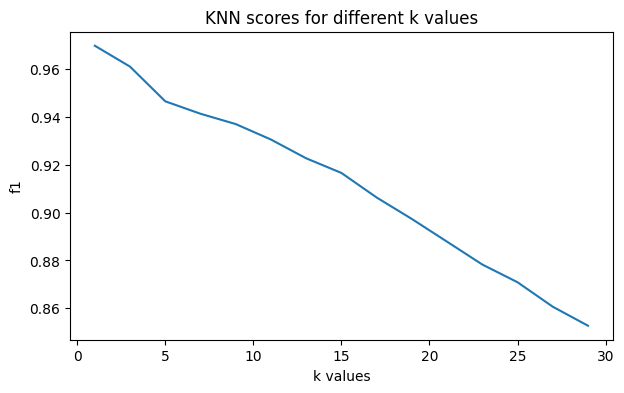

In [45]:
# plot the scoes for each k value
plt.figure(figsize=(7, 4))
plt.plot(k_values, knn_scores)
plt.xlabel('k values')
plt.ylabel('f1')
plt.title('KNN scores for different k values')

As we can see in the plot the more k value gets bigger, the more f1 score gets worse. To select the best k value, I select from `k_values` array with the index of the best precision score. 

The result is `k=1`.

In [46]:
# the best k value
k = k_values[np.argmax(knn_scores)]
print('The best k value is : ', k)

The best k value is :  1


In [47]:
# train the knn model with the best k=1 value
knn_final_model = KNeighborsClassifier(n_neighbors=k)
knn_final_model.fit(X_binary_train, y_binary_train)

KNeighborsClassifier(n_neighbors=1)

Accuracy score:
Train: 1.0 || Test: 0.9857142857142858
Precsion score:
Train: 1.0 || Test: 0.9823321554770318
Recall score:
Train: 1.0 || Test: 0.9754385964912281
f1 score:
Train: 1.0 || Test: 0.9788732394366197


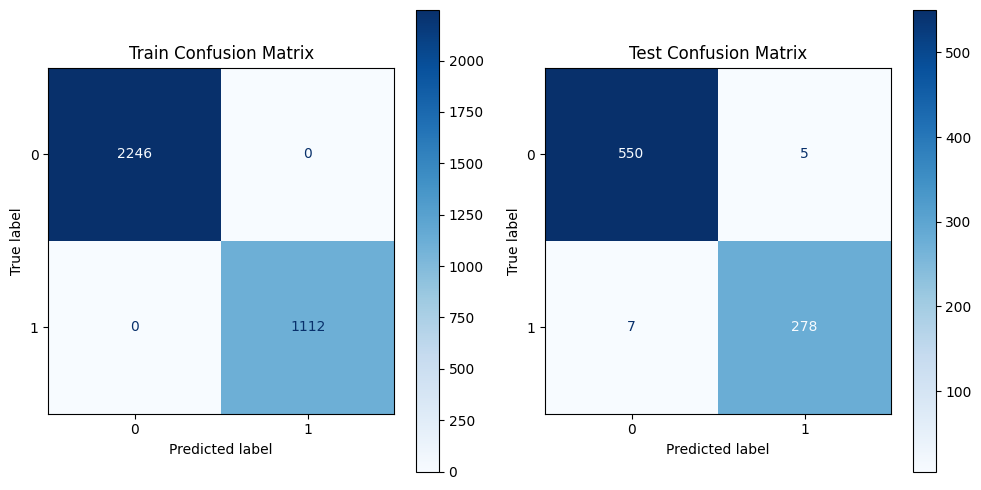

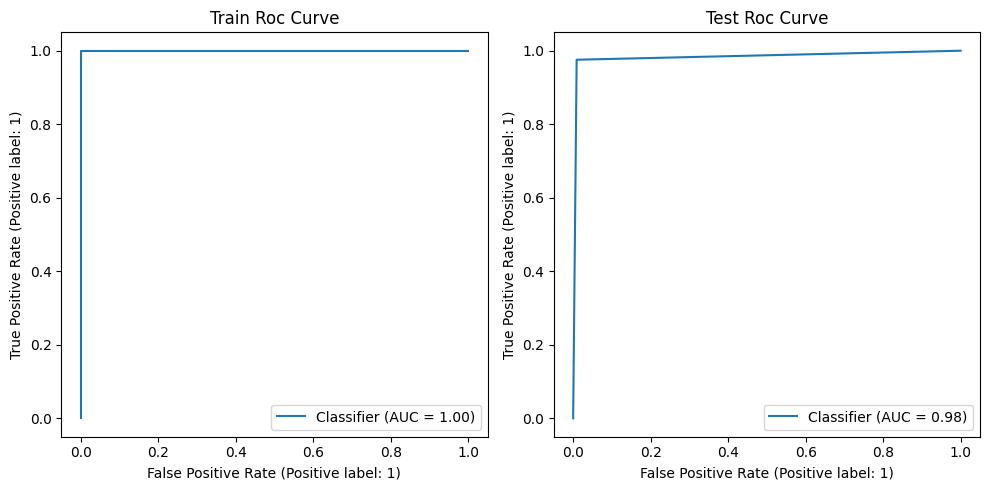

In [48]:
evaluate_models_performance(knn_final_model, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

## Logistic Regression

In [49]:
# define the logistic regression model to use and display its parameters
logReg_model = LogisticRegression()
logReg_model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

I perform a random search that aims to find the best combination of hyperparameters for logistic regression based on the provided parameter options:

1. Create a dictionnary `rsc_params` to define the parameter grid for the randomized search. It includes the following parameters for logistic regression:

    - `penalty`: Regularization penalty (l1 or l2).
    - `C`: Inverse of regularization strength (0.01, 0.1, 1, 10, 100, 1000).
    - `max_iter`: Maximum number of iterations (100, 1000, 2500, 5000).
    - `solver`: Solver algorithm options (lbfgs, liblinear, sag, saga).

2. Create an instance `randomSearch_logReg` of RandomizedSearchCV , which performs a randomized search over the defined parameter grid. It uses logistic regression as the base model (`logReg_model`):
    - `cv=5`: specifies a 5-fold cross-validation.
    - `n_jobs=-1`: allows the search to use all available CPU cores.
    - `verbose=1`: enables verbose output during the search process.
    - `scoring='f1'`: specifies the f1 scoring as an evaluation of the model for the chosed params.
3. Fit `randomSearch_logReg` into the training data (X_binary_train and y_binary_train) using the fit method.

In [50]:
# randomized search parameters for logistic regression
rsc_params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'max_iter': [100, 1000, 2500, 5000],
    'solver': ['lbfgs', 'liblinear', 'sag', 'saga']
    }
randomSearch_logReg = RandomizedSearchCV(logReg_model, rsc_params, cv=5, n_jobs=-1, verbose=1, scoring='f1')
randomSearch_logReg.fit(X_binary_train, y_binary_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\maria\AppData\Local\Programs\Python\

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10, 100, 1000],
                                        'max_iter': [100, 1000, 2500, 5000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['lbfgs', 'liblinear', 'sag',
                                                   'saga']},
                   scoring='f1', verbose=1)

Train the model with the best parameters found from the random search algorithm.

In [51]:
print(f'Best params: {randomSearch_logReg.best_params_}\nBest score: {randomSearch_logReg.best_score_}')
logReg_model = LogisticRegression(penalty=randomSearch_logReg.best_params_['penalty'], 
                                    C=randomSearch_logReg.best_params_['C'], 
                                    solver=randomSearch_logReg.best_params_['solver'], 
                                    max_iter=randomSearch_logReg.best_params_['max_iter'])
logReg_model.fit(X_binary_train, y_binary_train)

Best params: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 2500, 'C': 1000}
Best score: 0.9932762288247616


LogisticRegression(C=1000, max_iter=2500, penalty='l1', solver='liblinear')

Accuracy score:
Train: 1.0 || Test: 0.9940476190476191
Precsion score:
Train: 1.0 || Test: 1.0
Recall score:
Train: 1.0 || Test: 0.9824561403508771
f1 score:
Train: 1.0 || Test: 0.9911504424778761


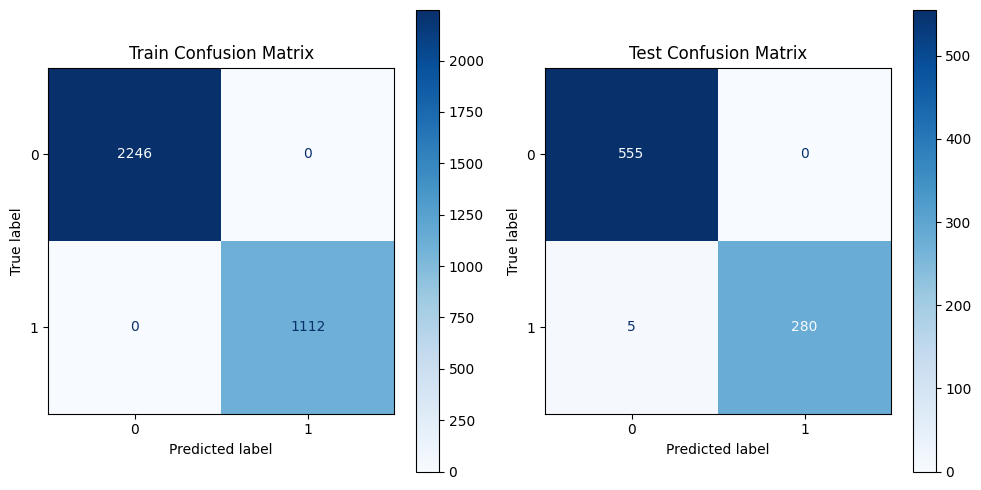

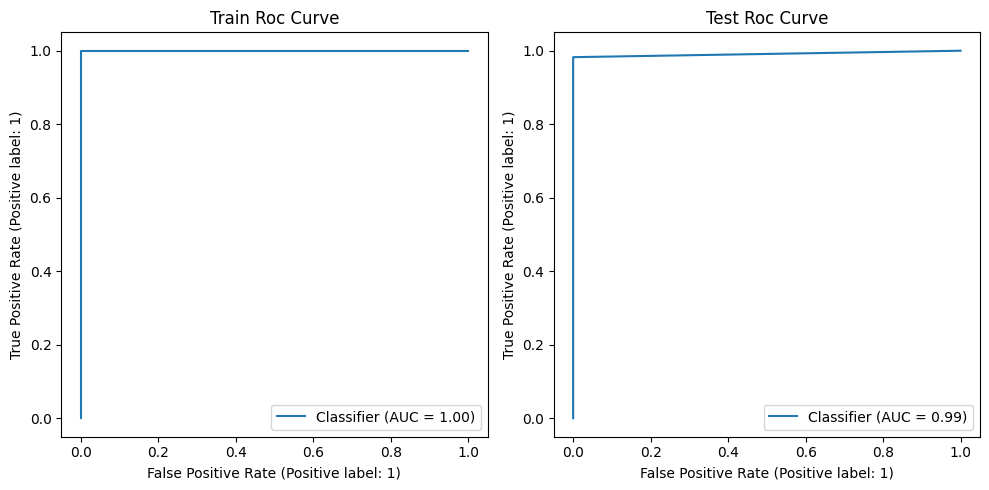

In [52]:
evaluate_models_performance(logReg_model, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

## Naive Bayes

For the classification with naive bayes I ran the experiments on 3 types of naive bayes models: Multinomial, Bernoulli and Gaussian with variating the var smoothing parameter.

Examine available parameters of each model

In [53]:
naiveBayes_model_multinomial = MultinomialNB()
naiveBayes_model_bernouli = BernoulliNB()
naiveBayes_model_gaussian = GaussianNB()
print(f'Multinomial model params: {naiveBayes_model_multinomial.get_params().keys()}')
print(f'Bernouli model params: {naiveBayes_model_bernouli.get_params().keys()}')
print(f'Gaussian model params: {naiveBayes_model_gaussian.get_params().keys()}')

Multinomial model params: dict_keys(['alpha', 'class_prior', 'fit_prior', 'force_alpha'])
Bernouli model params: dict_keys(['alpha', 'binarize', 'class_prior', 'fit_prior', 'force_alpha'])
Gaussian model params: dict_keys(['priors', 'var_smoothing'])


Experimentations:
- Generate an array of alphas using np.logspace to define a range of alpha values.
- Initialize lists to store the precision scores for each Naive Bayes model and alpha value: `naiveBayes_model_multinomial_scores`, `naive_bayes_bernouli_scores`, and `naiveBayes_model_gaussian_scores`.
- Iterate over the alpha values:
    - Instantiate the Naive Bayes models (MultinomialNB, BernoulliNB, and GaussianNB) with the corresponding alpha value.
    - Apply cross-validation using the cross_val_score function to calculate the f1 scores.
    - Append the mean precision scores to the respective lists.
- Plot the scores to visualize the precision scores for each model and alpha value.

In [54]:
alphas = np.logspace(0, -9, num=100)

naiveBayes_bernouli_scores = []
naiveBayes_model_multinomial_scores = []
naiveBayes_model_gaussian_scores = []

for alpha in alphas:
    naiveBayes_model_multinomial = MultinomialNB(alpha=alpha)
    naiveBayes_model_bernouli = BernoulliNB(alpha=alpha)
    naiveBayes_model_gaussian = GaussianNB(var_smoothing=alpha)
    
    multinomial_score = cross_val_score(naiveBayes_model_multinomial, X_binary_train, y_binary_train, cv=5, scoring='f1')
    bernouli_score = cross_val_score(naiveBayes_model_bernouli, X_binary_train, y_binary_train, cv=5, scoring='f1')
    gaussian_score = cross_val_score(naiveBayes_model_gaussian, X_binary_train, y_binary_train, cv=5, scoring='f1')
    
    naiveBayes_model_multinomial_scores.append(multinomial_score.mean())
    naiveBayes_bernouli_scores.append(bernouli_score.mean())
    naiveBayes_model_gaussian_scores.append(gaussian_score.mean())

Text(0, 0.5, 'f1')

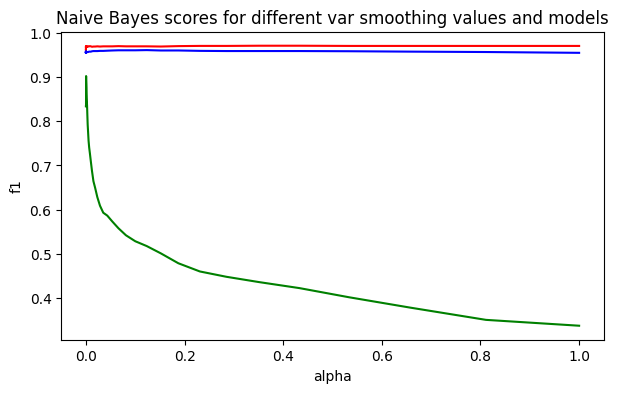

In [55]:
plt.figure(figsize=(7, 4))
plt.plot(alphas, naiveBayes_model_multinomial_scores, label='Multinomial', color='red')
plt.plot(alphas, naiveBayes_bernouli_scores, label='Bernouli', color='blue')
plt.plot(alphas, naiveBayes_model_gaussian_scores, label='Gaussian', color='green')
plt.title('Naive Bayes scores for different var smoothing values and models')
plt.xlabel('alpha')
plt.ylabel('f1')

As we can see in the plot the mutinomial model reached the highest values of f1 scores. Therefore I will reinstantiate the multinomial model with the best alpha values and then train it on the whole training dataset.

In [56]:
best_param_naive_bayes = alphas[np.argmax(np.array(naiveBayes_model_multinomial_scores))]
best_score_naive_bayes = multinomial_score.max()
best_param_naive_bayes, best_score_naive_bayes

(0.43287612810830584, 0.9750566893424037)

In [57]:
print(f'Best params: {best_param_naive_bayes} \nBest score: {best_score_naive_bayes}')

Best params: 0.43287612810830584 
Best score: 0.9750566893424037


In [58]:
# We will choose the multinomial model of naive bayes
naiveBayes_model_multinomial = MultinomialNB(alpha=best_param_naive_bayes)
naiveBayes_model_multinomial.fit(X_binary_train, y_binary_train)

MultinomialNB(alpha=0.43287612810830584)

Accuracy score:
Train: 0.9851101846337106 || Test: 0.9857142857142858
Precsion score:
Train: 0.9862637362637363 || Test: 1.0
Recall score:
Train: 0.9685251798561151 || Test: 0.9578947368421052
f1 score:
Train: 0.9773139745916516 || Test: 0.978494623655914


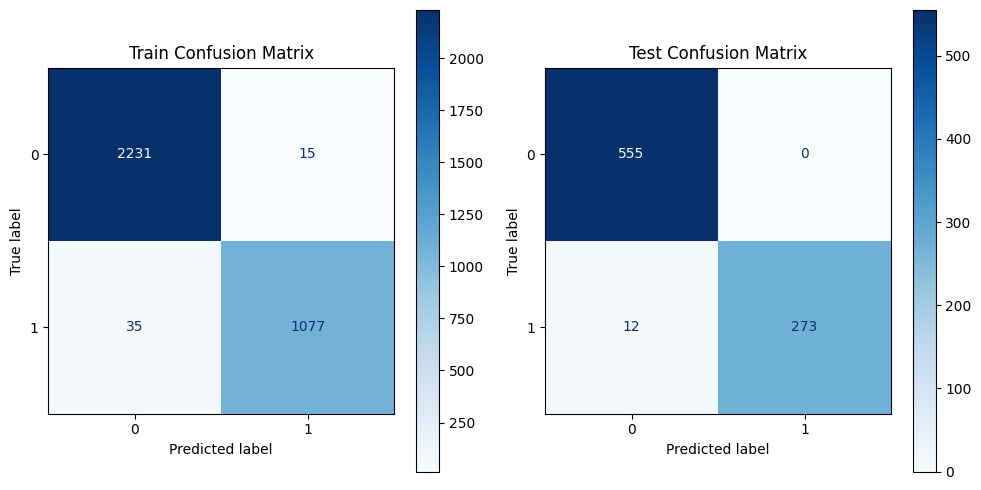

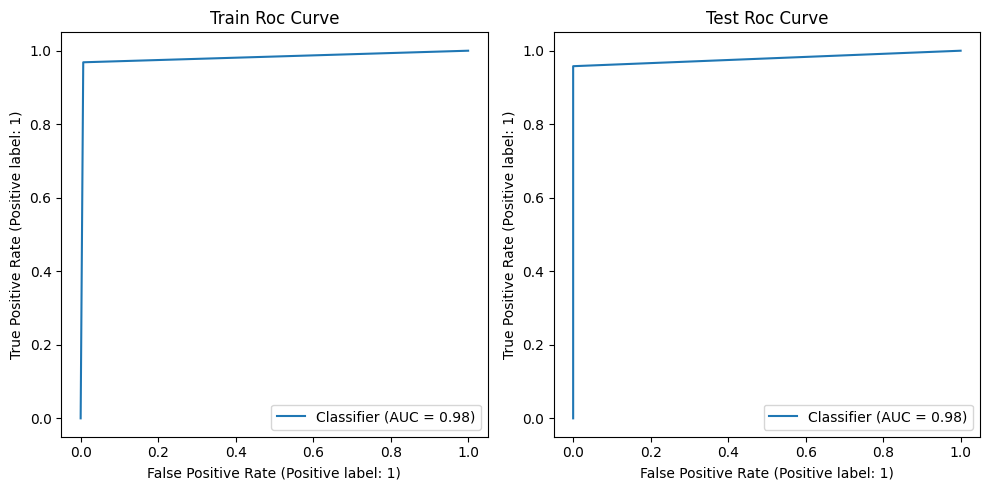

In [59]:
evaluate_models_performance(naiveBayes_model_multinomial, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

## SVM

Perform a grid search that aims to find the best combination of hyperparameters for the SVM based on the provided parameter options:
1. Create a dictionnary `rand_params_svm` to define the parameter grid for the grid search. It includes the following parameters for SVM:

    - `C`: Inverse of regularization strength (0.01, 0.1, 1, 10, 100, 1000).
    - `kernel`:  It determines the type of decision boundary to be created (linear, rbf, poly).
    - `gamma`: It defines how far the influence of a single training example reaches. Higher values result in a more complex decision boundary. (1, 0.1, 0.01, 0.001, 0.001).

2. Create an instance `gridSearch_svm` of RandomizedSearchCV , which performs a randomized search over the defined parameter grid. It uses logistic regression as the base model (`logReg_model`):
    - `cv=5`: specifies a 5-fold cross-validation.
    - `n_jobs=-1`: allows the search to use all available CPU cores.
    - `verbose=1`: enables verbose output during the search process.
    - `scoring='f1'`: specifies the f1 scoring as an evaluation of the model for the chosed params.
3. Fit `gridSearch_svm` into the training data (X_binary_train and y_binary_train) using the fit method.

In [60]:
svm_model = SVC()
svm_model.get_params().keys() 

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [61]:
rand_params_svm =  {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.001]
}

gridSearchCV_svm = GridSearchCV(svm_model, rand_params_svm, cv=5, verbose=1, scoring='f1', n_jobs=-1)
gridSearchCV_svm.fit(X_binary_train, y_binary_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.001],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='f1', verbose=1)

In [62]:
print(f'Best params: {gridSearchCV_svm.best_params_} \nBest score: {gridSearchCV_svm.best_score_}')

Best params: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'} 
Best score: 0.9937297160198216


In [63]:
svm_model = SVC(C=gridSearchCV_svm.best_params_['C'], gamma=gridSearchCV_svm.best_params_['gamma'], kernel=gridSearchCV_svm.best_params_['kernel'])
svm_model.fit(X_binary_train, y_binary_train)

SVC(C=0.1, gamma=1, kernel='linear')

Accuracy score:
Train: 1.0 || Test: 0.9916666666666667
Precsion score:
Train: 1.0 || Test: 1.0
Recall score:
Train: 1.0 || Test: 0.9754385964912281
f1 score:
Train: 1.0 || Test: 0.9875666074600356


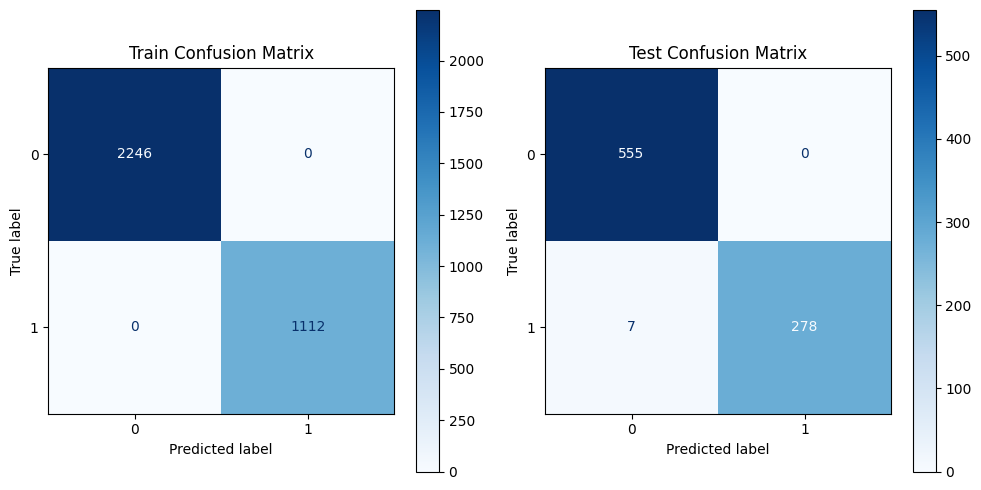

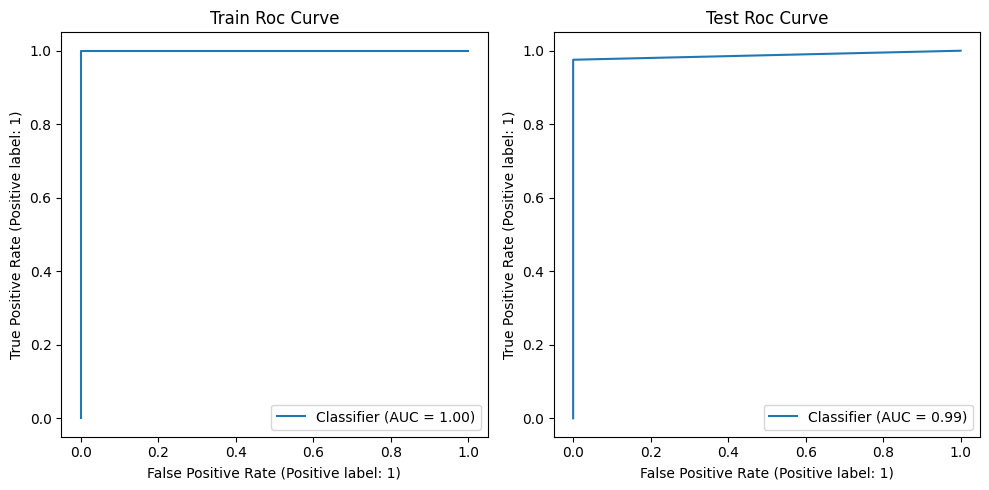

In [64]:
evaluate_models_performance(svm_model, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

## Decision tree

Examine the Decision Tree model parameters and choose the most important ones to run experiments on

In [65]:
decTree_model = DecisionTreeClassifier()
decTree_model.get_params().keys()    

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

Experiments:
- Perform the random search (grid search takes a lot of time) on the decision tree parametrs grid `param_grid_decTree` with the options:
    - 'max_depth': It defines the max depth of the decision tree (5, 10, 15, 20, None).
    - 'min_samples_split': The minimum number of samples required to split an internal node (2, 5, 10).
    - 'min_samples_leaf': The minimum number of samples required to be at a leaf node (1, 2, 4).
    - 'max_features': The number of features to consider when looking for the best split ('sqrt', 'log2', None).
- I used the same `RandomizedSearchCV` parameters as the logistic regression.
- Fit the descision tree model with the best params found.
- Evaluate the model.

In [66]:
param_grid_decTree = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

randSearchCV_decTree = RandomizedSearchCV(decTree_model, param_grid_decTree, cv=5, verbose=1, scoring='f1', n_jobs=-1)
randSearchCV_decTree.fit(X_binary_train, y_binary_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10]},
                   scoring='f1', verbose=1)

In [67]:
print(f'Best params: {randSearchCV_decTree.best_params_} \nBest score: {randSearchCV_decTree.best_score_}')

Best params: {'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10} 
Best score: 0.9678136273129366


In [68]:
decTree_model = DecisionTreeClassifier(max_depth=randSearchCV_decTree.best_params_['max_depth'], min_samples_split=randSearchCV_decTree.best_params_['min_samples_split'], min_samples_leaf=randSearchCV_decTree.best_params_['min_samples_leaf'], max_features=randSearchCV_decTree.best_params_['max_features'])
decTree_model.fit(X_binary_train, y_binary_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10)

Accuracy score:
Train: 0.9883859440142942 || Test: 0.9702380952380952
Precsion score:
Train: 0.9777382012466608 || Test: 0.9744525547445255
Recall score:
Train: 0.987410071942446 || Test: 0.9368421052631579
f1 score:
Train: 0.9825503355704699 || Test: 0.9552772808586761


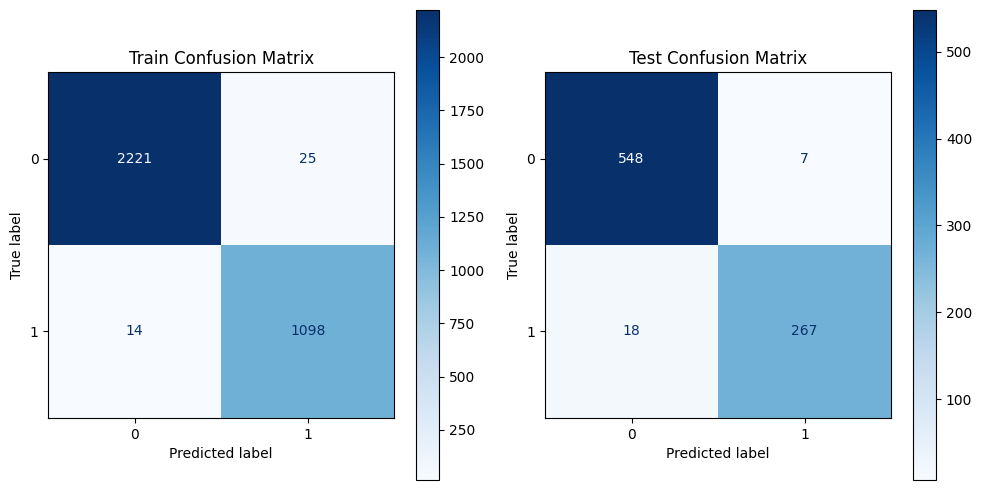

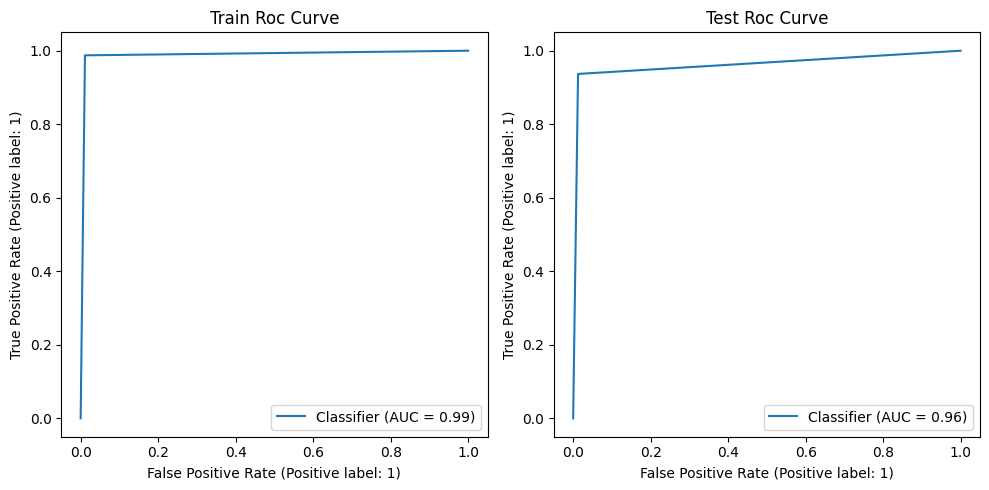

In [69]:
evaluate_models_performance(decTree_model, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

## MLP

For the MLP model, I will run it on both the binary data and frequency representation data to examine if the data representation influence on the model quality.

Examine the MLP classifier parameters 

In [27]:
mlp_model = MLPClassifier()
mlp_model.get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Experiments:
1. Perform the random search on the MLP parametrs grid `param_grid_decTree` with the options:
    - `activation`: It determines the activation function for the hidden layers. The choice of activation function can impact the model's ability to learn complex patterns and make accurate predictions ('identity', 'logistic', 'tanh', and 'relu').
    - `solver`: This parameter specifies the optimization algorithm used to train the MLP model. The solver affects the convergence speed and the ability to find global optima ('lbfgs', 'sgd', and 'adam').
    - `alpha`: It controls the regularization strength that helps prevent overfitting. The regularization term adds a penalty for large parameter values (0.0001, 0.001, 0.01, 0.1).
    - `learning_rate`: This parameter defines how the learning rate is updated during training. It affects the step size at each iteration and influences the convergence speed ('constant', 'invscaling', 'adaptive').
    - `max_iter`: It specifies the maximum number of iterations or epochs the MLP model should be trained for. A higher number of iterations allows the model to potentially improve its performance, but it also increases the training time (100, 200, 300, 400, 500).
2. I used the same `RandomizedSearchCV` parameters as the logistic regression.
3. Fit the MLP model with the best params found.
4. Evaluate the model.

In [28]:
mlp_grid_params = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [100, 200, 300, 400, 500]
}

### Binary representation

In [29]:
# size of the input layer
X_binary_train.shape[1]

10000

In [30]:
# size of hidden layer 2/3 of the size of input layer
hidden_layer_size = int((2/3) * X_binary_train.shape[1])
hidden_layer_size

6666

In [31]:
mlp_grid_search = RandomizedSearchCV(mlp_model, mlp_grid_params, cv=5, verbose=1, scoring='f1')
mlp_grid_search.fit(X_binary_train, y_binary_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimiza

RandomizedSearchCV(cv=5, estimator=MLPClassifier(),
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [100, 200, 300, 400, 500],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='f1', verbose=1)

In [32]:
mlp_model_binary = MLPClassifier(hidden_layer_sizes=hidden_layer_size, 
                                activation=mlp_grid_search.best_params_['activation'],
                                solver=mlp_grid_search.best_params_['solver'],
                                alpha=mlp_grid_search.best_params_['alpha'],
                                learning_rate=mlp_grid_search.best_params_['learning_rate'],
                                max_iter=mlp_grid_search.best_params_['max_iter'])
mlp_model_binary.fit(X_binary_train, y_binary_train)

MLPClassifier(activation='logistic', alpha=0.1, hidden_layer_sizes=6666,
              learning_rate='adaptive')

Accuracy score:
Train: 0.9985110184633711 || Test: 0.9928571428571429
Precsion score:
Train: 0.9990982867448152 || Test: 1.0
Recall score:
Train: 0.9964028776978417 || Test: 0.9789473684210527
f1 score:
Train: 0.9977487618190005 || Test: 0.9893617021276596


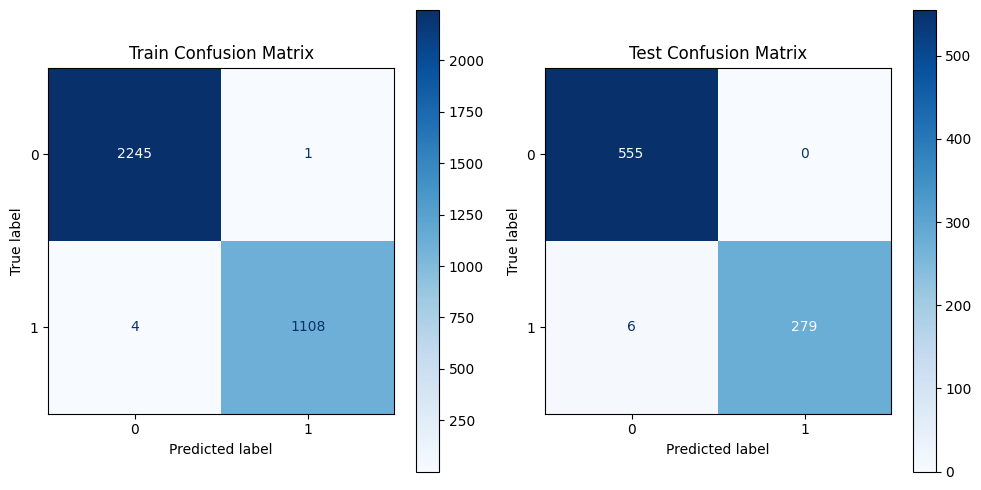

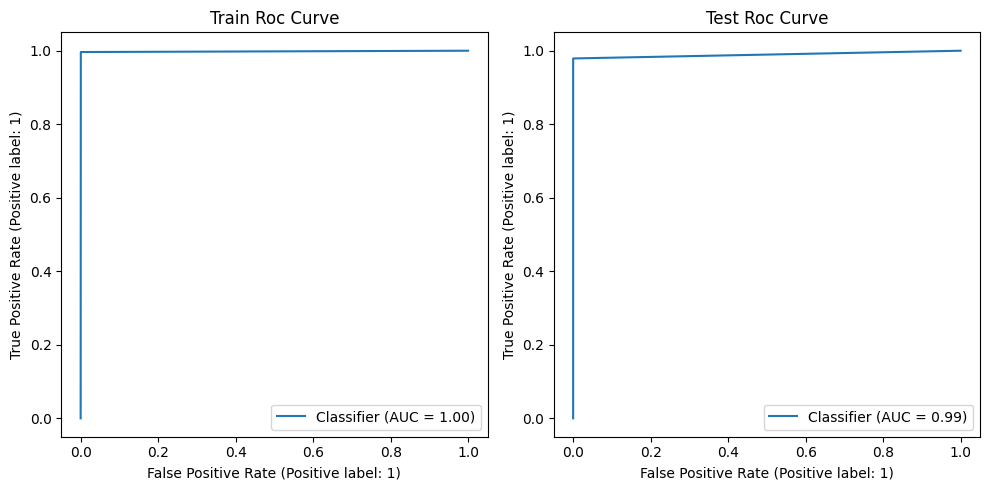

In [33]:
evaluate_models_performance(mlp_model_binary, X_binary_test, y_binary_test, X_binary_train, y_binary_train)

### Frequency representation

In [34]:
X_freq_train.shape[1]

10000

In [38]:
mlp_random_search_freq = RandomizedSearchCV(mlp_model, mlp_grid_params, cv=5, verbose=1, scoring='f1')
mlp_random_search_freq.fit(X_freq_train, y_freq_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.

RandomizedSearchCV(cv=5, estimator=MLPClassifier(),
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [100, 200, 300, 400, 500],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='f1', verbose=1)

In [41]:
mlp_model_freq1 = MLPClassifier(hidden_layer_sizes=hidden_layer_size, 
                                activation=mlp_random_search_freq.best_params_['activation'],
                                solver=mlp_random_search_freq.best_params_['solver'],
                                alpha=mlp_random_search_freq.best_params_['alpha'],
                                learning_rate=mlp_random_search_freq.best_params_['learning_rate'],
                                max_iter=mlp_random_search_freq.best_params_['max_iter'])
mlp_model_freq1.fit(X_freq_train, y_freq_train)

MLPClassifier(activation='identity', alpha=0.1, hidden_layer_sizes=6666,
              learning_rate='invscaling', max_iter=300)

Accuracy score:
Train: 1.0 || Test: 0.9857142857142858
Precsion score:
Train: 1.0 || Test: 0.989247311827957
Recall score:
Train: 1.0 || Test: 0.968421052631579
f1 score:
Train: 1.0 || Test: 0.9787234042553192


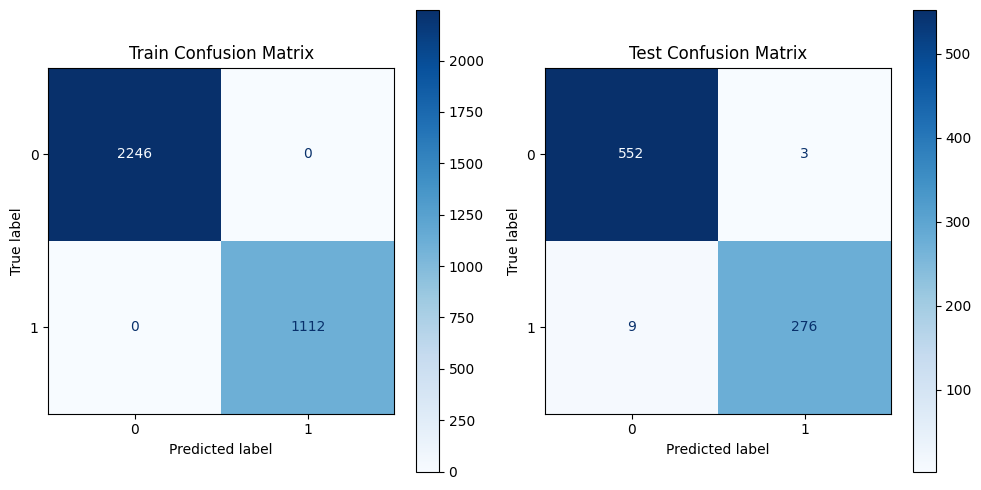

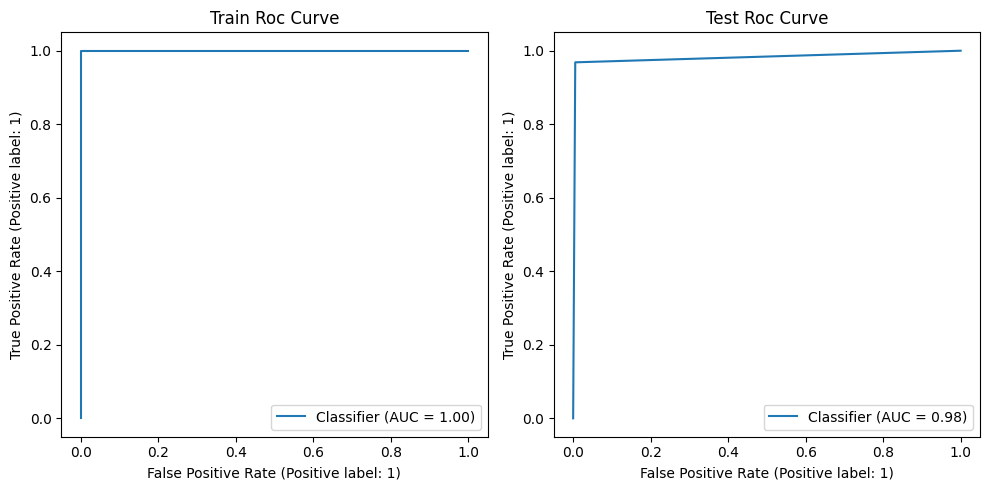

In [42]:
evaluate_models_performance(mlp_model_freq1, X_freq_test, y_freq_test, X_freq_train, y_freq_train)

### Analyze
- For the both representations, the models reached high metrics scores.
- The binary representation was slightly better than the frequency representation in terms of precision score.

# Models Comparaison

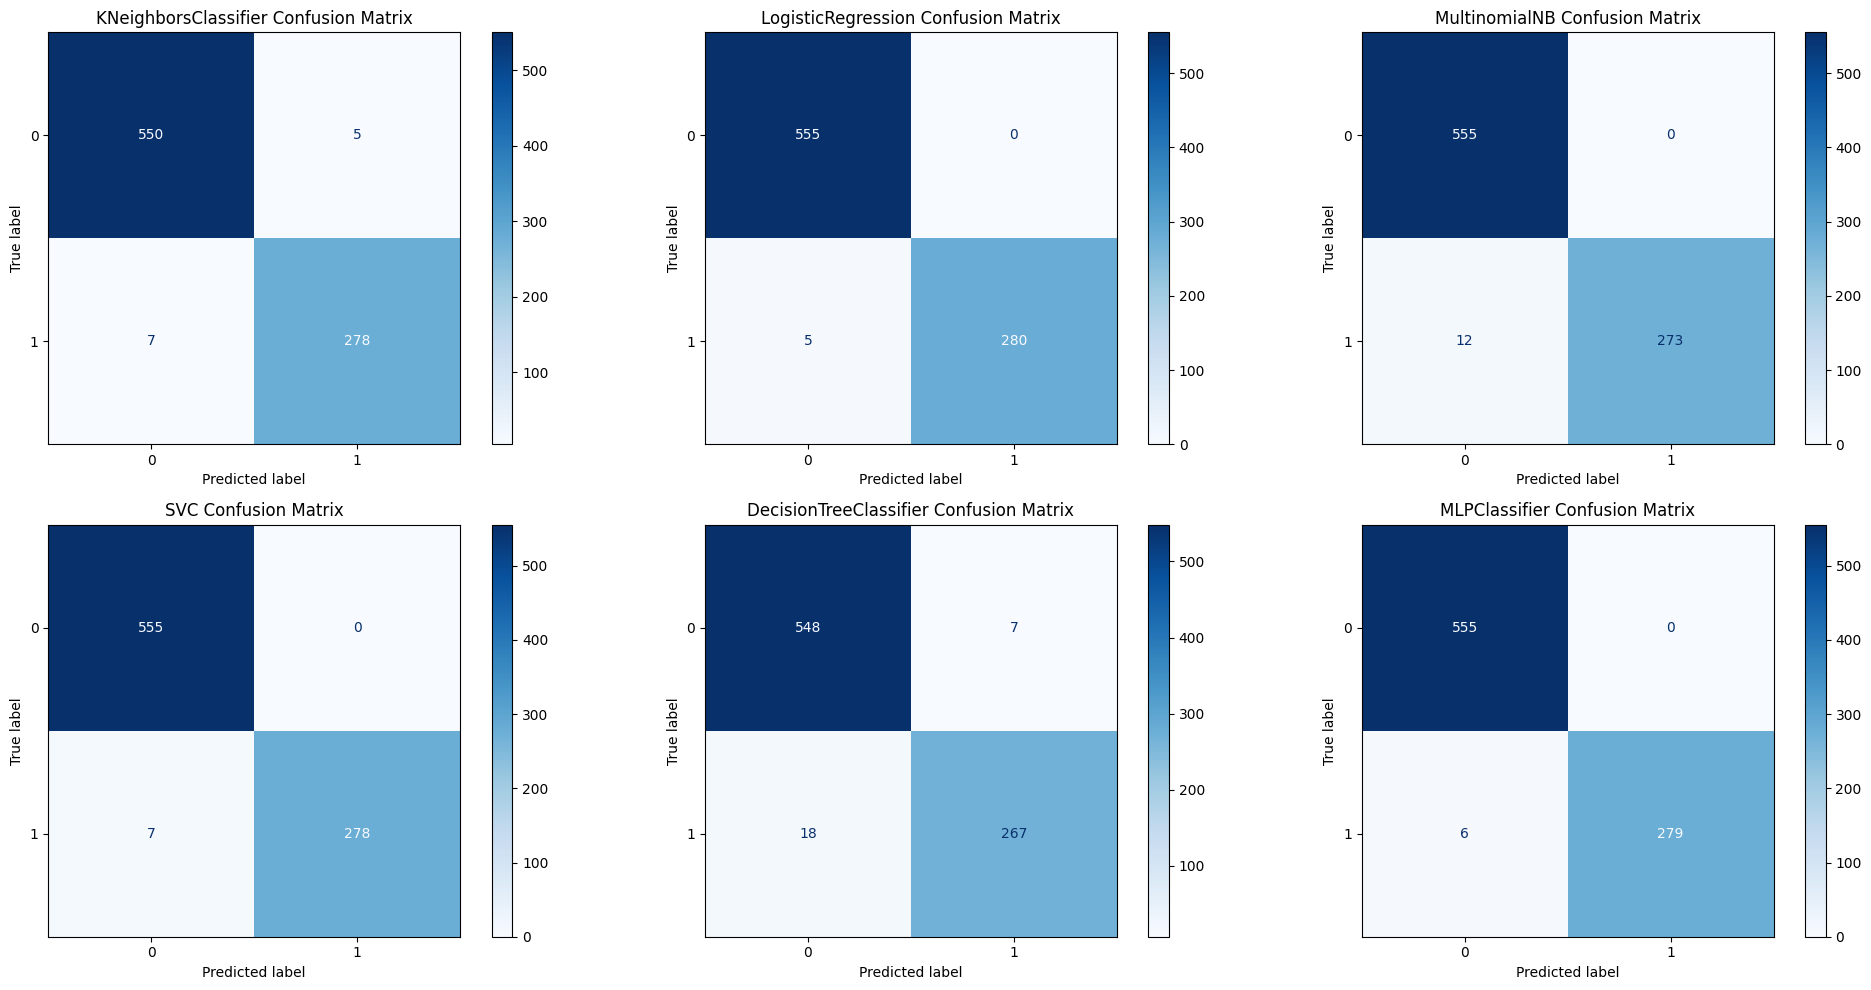

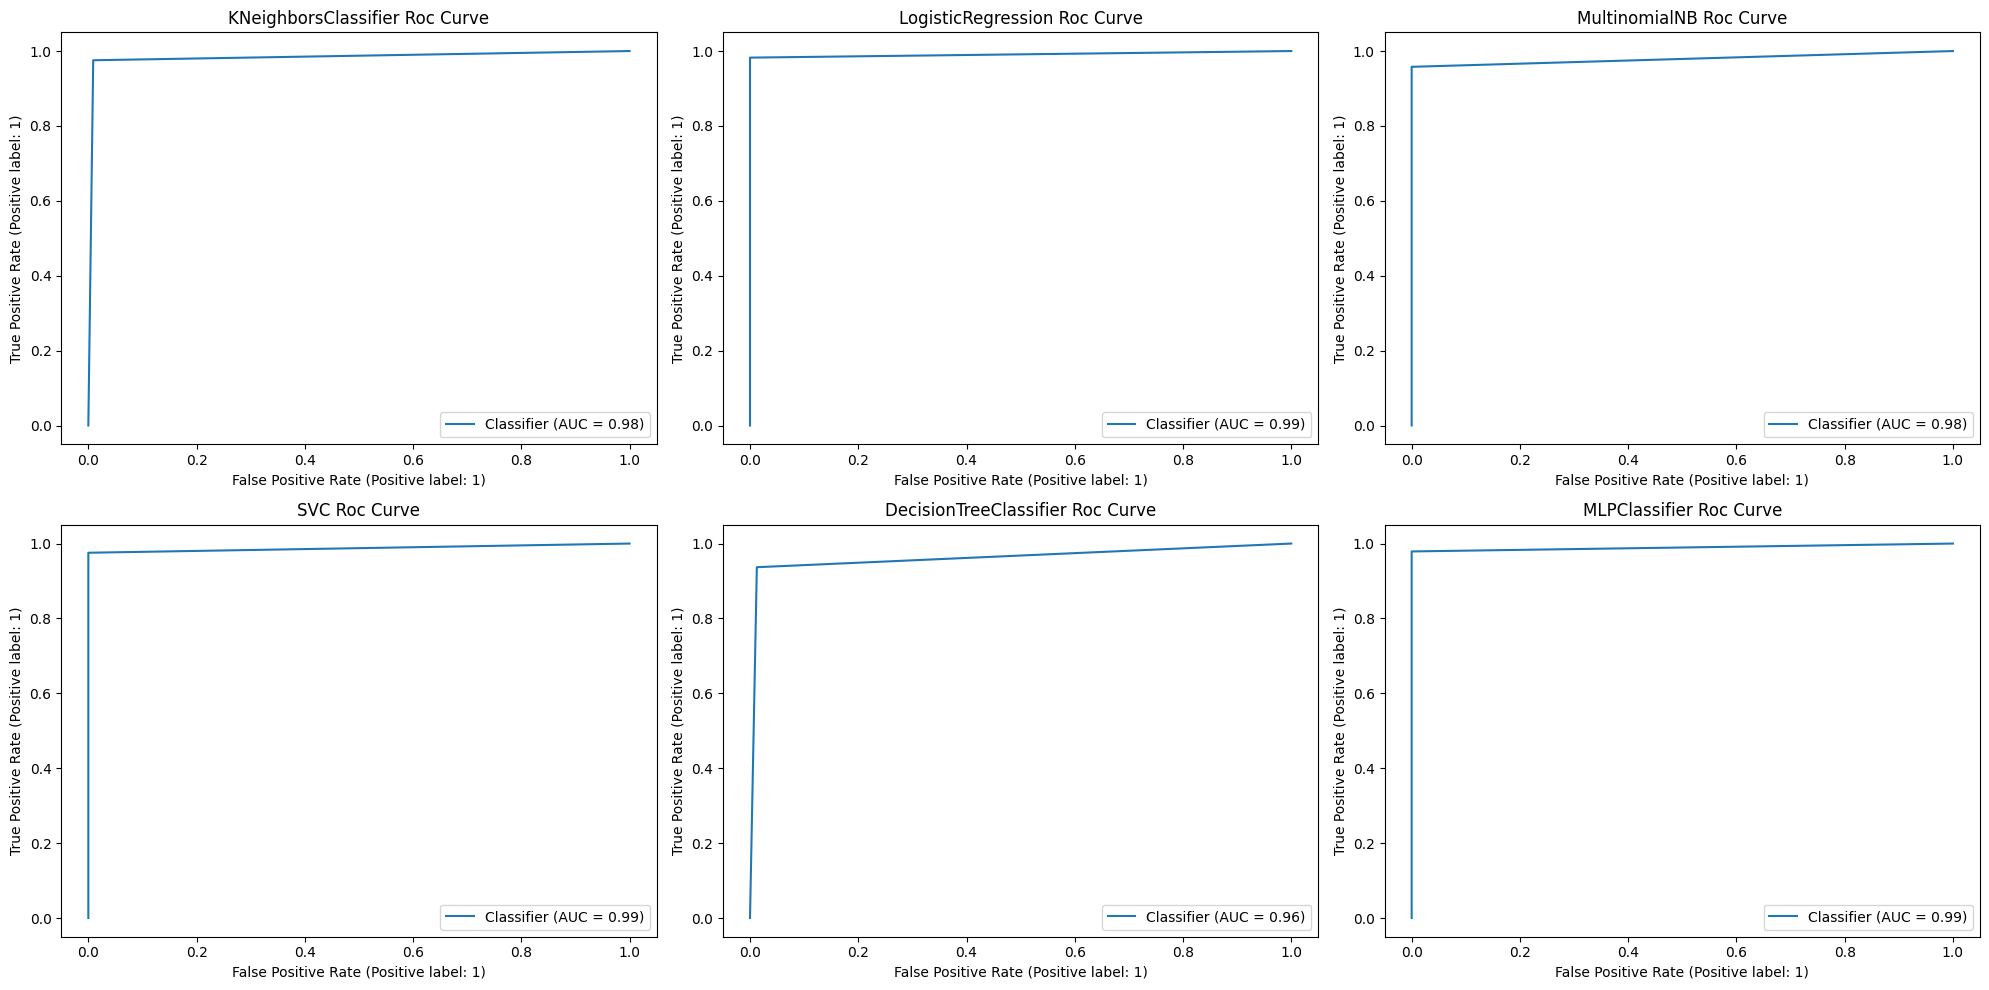

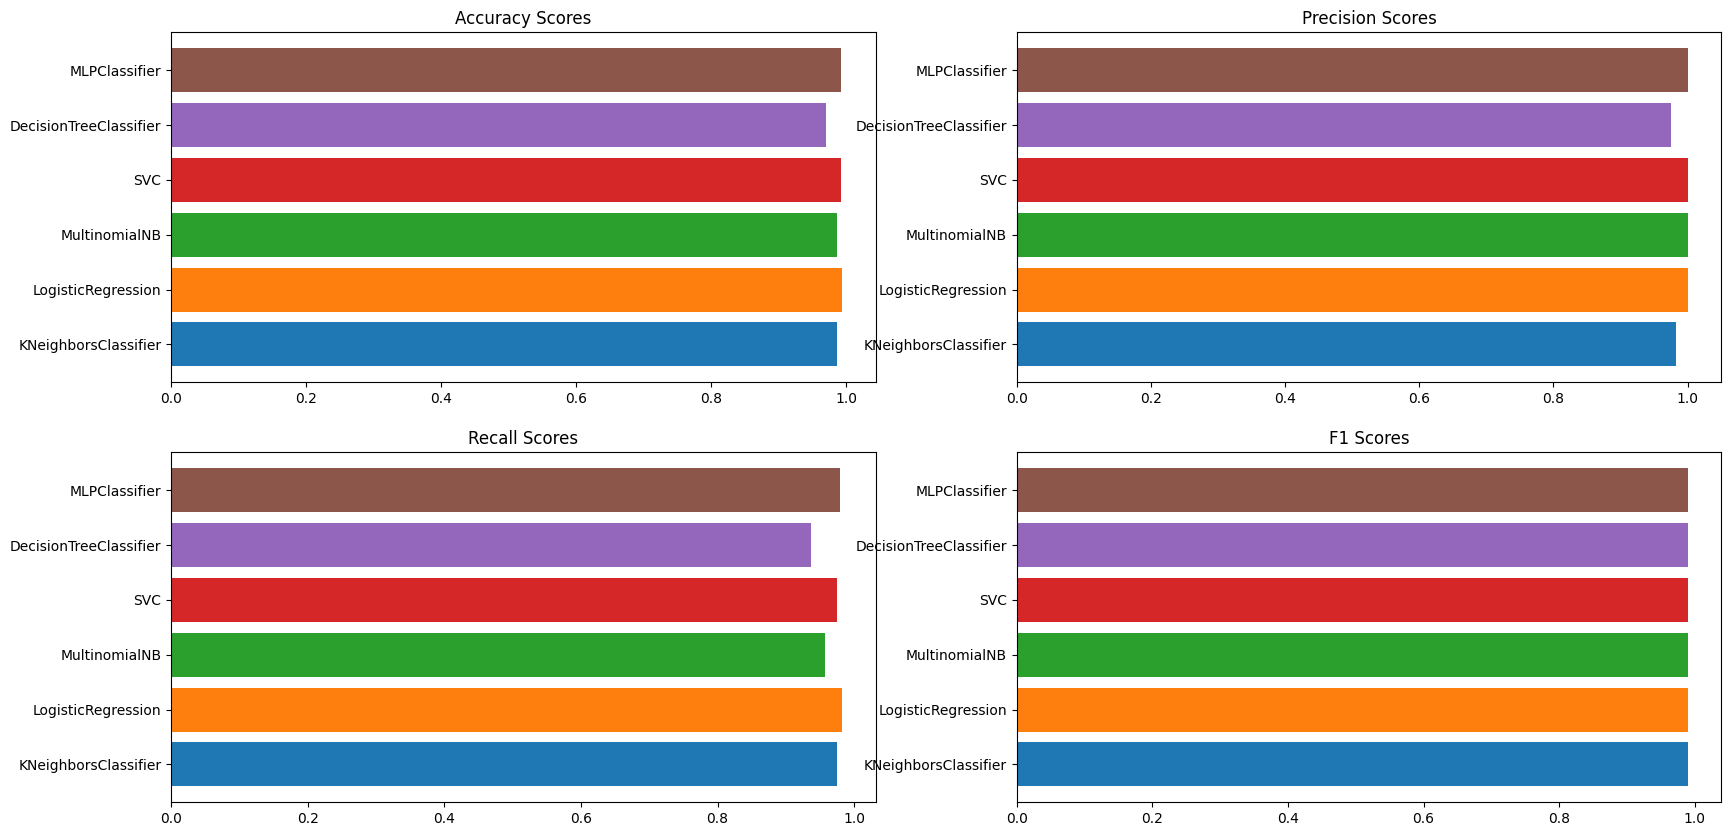

In [111]:
models_compare([knn_final_model, logReg_model, naiveBayes_model_multinomial, svm_model, decTree_model, mlp_model_binary], X_binary_test, y_binary_test)

## Analyze
- In the context of spam classification, precision is the most important metric to evaluate the performance of our model (ham messages can't be classified as spam).
- Across all classifiers, the metrics score achieved was consistently high, surpassing 95%. This indicates that the models performed exceptionally well in accurately classifying spam and ham messages.
- In terms of precision, the classifiers **Logistic regression**, **Naive Bayes**, **SVM**, **MLP** achieved a perfect precision score of 1. This means that these classifiers were highly reliable in correctly labeling spam messages without misclassifying ham messages as spam.